In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import statistics

data = pd.read_csv ("Allsupernovae.csv") #reading in supernovae data and creating data frame 'data'

cosmo = FlatLambdaCDM(H0=70, Om0=0.295) #H0 and omega_m values from Betoule, cosmological model assuming flat Universe
cosmo_high = FlatLambdaCDM(H0=70, Om0=0.84) #trying other (extreme) cosmology values for comparison 
cosmo_low = FlatLambdaCDM(H0=70, Om0=0.01) 

#Calculating Distances
#Om0=0.295
data['d_L'] = cosmo.luminosity_distance(data.zcmb) #changing cmb redshift to distance in Mpc
data['d_L'] *= pow(10,6) #converting Mpc to pc for distance modulus equation

data['d_L_high'] = cosmo_high.luminosity_distance(data.zcmb)
data['d_L_high'] *= pow(10,6)

data['d_L_low'] = cosmo_low.luminosity_distance(data.zcmb)
data['d_L_low'] *= pow(10,6)

#Distance modulus eq 
#mu = 5log(d_L/10pc) 

data['mu'] = 5*(np.log10(data.d_L/10))
data['mu_high'] = 5*(np.log10(data.d_L_high/10))
data['mu_low'] = 5*(np.log10(data.d_L_low/10))


In [2]:
#previous data for comparison
#step function for abs. mag
data['MBstep'] = data.loc[data['LogMst'] >= 10,['MB1','deltaM']].sum(axis=1) #adds deltaM to MB1 if LogMst >=10
data['MBstep'].fillna(data.MB1, inplace=True) #otherwise does nothing to MB1

#Distance modulus eq
data['distance_modulus'] = data.mb - (data.MB1 - data.alpha*data.X1 + data.beta*data.c) #includes 'distance modulus' column
                                                                                        #into data frame filled with sol. to
                                                                                        #this equation (only in this window)
        

#Distance Modulus with abs. mag. step function included    
data['distance_modulus_step'] = data.mb - (data.MBstep - data.alpha*data.X1 + data.beta*data.c)


#Residuals
data['residuals_nostep'] = data.distance_modulus - data.mu
data['residuals_step'] = data.distance_modulus_step - data.mu
data['residuals_nostep_high'] = data.distance_modulus - data.mu_high
data['residuals_step_high'] = data.distance_modulus_step - data.mu_high
data['residuals_nostep_low'] = data.distance_modulus - data.mu_low
data['residuals_step_low'] = data.distance_modulus_step - data.mu_low

#Standard Deviation
stat1 = statistics.stdev(data.residuals_nostep)
stat2 = statistics.stdev(data.residuals_step)
stat1_high = statistics.stdev(data.residuals_nostep_high)
stat2_high = statistics.stdev(data.residuals_step_high)
stat1_low = statistics.stdev(data.residuals_nostep_low)
stat2_low = statistics.stdev(data.residuals_step_low)

print(stat1, stat2) 
print(stat1_high, stat2_high)
print(stat1_low, stat2_low)


0.17082754379621903 0.16914937913948594
0.23086964676470761 0.22424649057854495
0.21775319576870758 0.22184928378808993


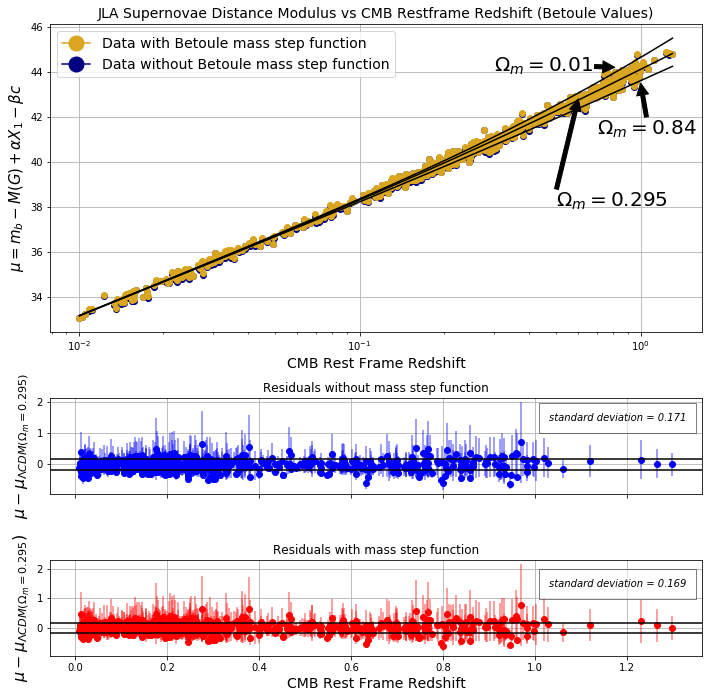

In [7]:
#plotting line graph of distance modulus vs. redshift
fig = plt.figure(1,figsize=(10,10))
plt.subplot2grid((60,1), (0,0), rowspan = 30)
plt.plot(data.zcmb, data.distance_modulus,'o', color='navy', alpha=1)


#Labelling axes and putting title and grid 
plt.title('JLA Supernovae Distance Modulus vs CMB Restframe Redshift (Betoule Values)', fontsize=14)
plt.xscale('log')
plt.xlabel('CMB Rest Frame Redshift', fontsize=14)
plt.ylabel(r'$\mu = m_{b} - M(G) + \alpha X_{1} - \beta c$', fontsize=15)
plt.grid(True)

#plotting dist. mod. with step function included
plt.plot(data.zcmb, data.distance_modulus_step,'o', color='goldenrod', alpha=1)


#Making a legend
gold_line = mlines.Line2D([], [], color='goldenrod', marker='o',markersize=15, label='Data with Betoule mass step function')
navy_line = mlines.Line2D([], [], color='navy', marker='o',markersize=15, label='Data without Betoule mass step function')


plt.legend(handles=[gold_line, navy_line,], fontsize=14)


#plotting cosmological fit
plt.plot(np.sort(data.zcmb), np.sort(data.mu),'k')
plt.plot(np.sort(data.zcmb), np.sort(data.mu_low), 'k')
plt.plot(np.sort(data.zcmb), np.sort(data.mu_high), 'k')

#annotating graph 
plt.annotate('$\Omega_m = 0.01$', xy=(0.81, 44.2), xytext=(0.3, 44), arrowprops=dict(facecolor='black'), fontsize=20)
plt.annotate('$\Omega_m = 0.84$', xy=(1, 43.5), xytext=(0.7, 41.2), arrowprops=dict(facecolor='black'), fontsize=20)
plt.annotate('$\Omega_m = 0.295$', xy=(0.6, 42.8), xytext=(0.5, 38), arrowprops=dict(facecolor='black'), fontsize=20)


#errors propogation
data['err_lens'] = 0.055*data.zcmb  #lensing error, see Betoule et al. 2014 section 5


data['error_dm'] = data.error_mb + (data.error_MB1 + (data.error_alpha*data.X1 + data.alpha*data.error_X1) + 
                    (data.beta*data.error_c + data.c*data.error_beta)) + data.err_lens

data['error_dm_step'] = (data.error_mb + ((data.error_MB1 + data.error_deltaM) + (data.error_alpha*data.X1 + 
                        data.alpha*data.error_X1) + (data.beta*data.error_c + data.c*data.error_beta)) 
                        + data.err_lens)

#residuals
low_error = data.residuals_nostep + data.error_dm
up_error = data.residuals_nostep + data.error_dm
asym_error = [low_error, up_error]

low_errorstep = data.residuals_step + data.error_dm_step
up_errorstep = data.residuals_step + data.error_dm_step
asym_errorstep = [low_errorstep, up_errorstep]

#plotting residual subplots
plt.subplot2grid((60,1),(30,0), rowspan = 13)
plt.plot(data.zcmb, data.residuals_nostep, 'bo')
plt.title('Residuals without mass step function')
plt.text(1.03, 1.4, 'standard deviation = 0.171', style='italic', bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})
plt.tick_params(labelbottom='off')
plt.ylabel(r'$\mu - \mu_{\Lambda CDM (\Omega_m = 0.295)}$', fontsize=16)
plt.errorbar(data.zcmb, data.residuals_nostep, fmt='none', yerr=asym_error, color='blue', alpha=0.5)
plt.axhline(y=stat1, color='k')
plt.axhline(y=(-stat1), color='k')
plt.grid(True)

plt.subplot2grid((60,1),(43,0), rowspan = 13)
plt.plot(data.zcmb,data.residuals_step, 'ro')
plt.title('Residuals with mass step function')
plt.axhline(y=stat2, color='k')
plt.axhline(y=(-stat2), color='k')
plt.text(1.03, 1.4, 'standard deviation = 0.169', style='italic', bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})
plt.xlabel('CMB Rest Frame Redshift', fontsize=14)
plt.ylabel(r'$\mu - \mu_{\Lambda CDM (\Omega_m = 0.295})$', fontsize=16)
plt.errorbar(data.zcmb, data.residuals_step, yerr=asym_errorstep, fmt='none', color='red', alpha=0.5)
plt.grid(True)
plt.tight_layout()
plt.show()

fig.savefig('Distance Modulus Cosmo (JLA)(errors).pdf')

plt.close(fig)